## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

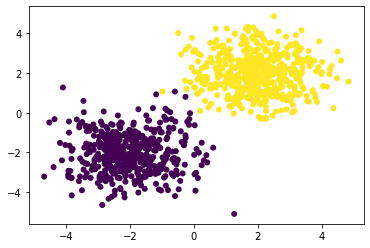

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

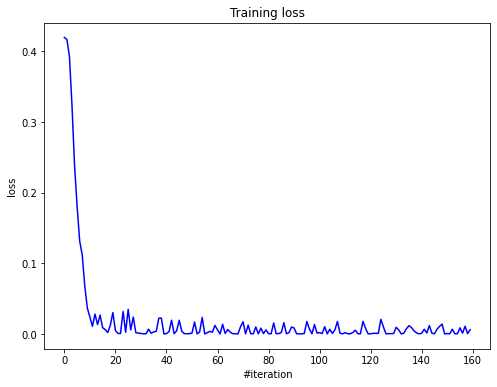

Current loss: 0.006120


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.fit_transform(y_val.reshape(-1, 1))
y_test = encoder.fit_transform(y_test.reshape(-1, 1))

In [10]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))


X_train.shape

(50000, 784)

In [11]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1

In [12]:

from sklearn.metrics import accuracy_score
from tqdm import tqdm

def investigate_net_on_mnist(net, criterion, optimizer, optimizer_config, n_epoch, batch_size):
    optimizer_state = {}
    loss_history = []
    accuracy_history = []

    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
        
        net.evaluate()
        accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val.argmax(axis=-1)))
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)    
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        
        plt.subplot(1, 2, 2)
        plt.title("Val accuracy")
        plt.xlabel("#epoch")
        plt.ylabel("accuracy")
        plt.plot(accuracy_history, 'b')
        plt.show()
        
        print('Current loss: %f' % loss)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
# Your code goes here. ################################################

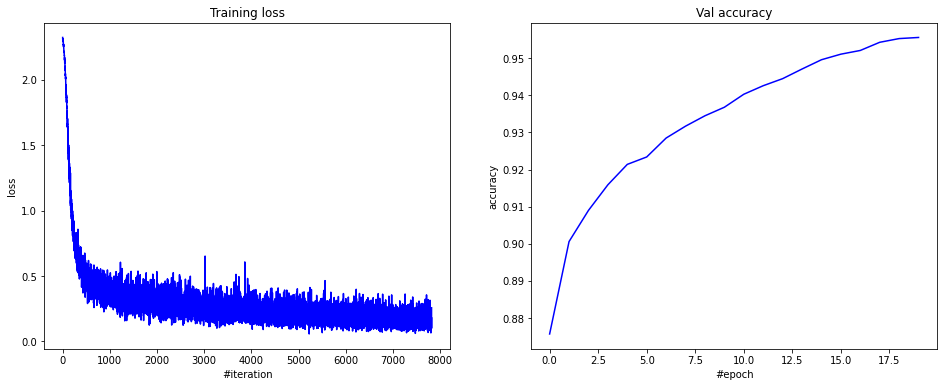

Current loss: 0.257611


In [14]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, sgd_momentum, optimizer_config, n_epoch, batch_size)

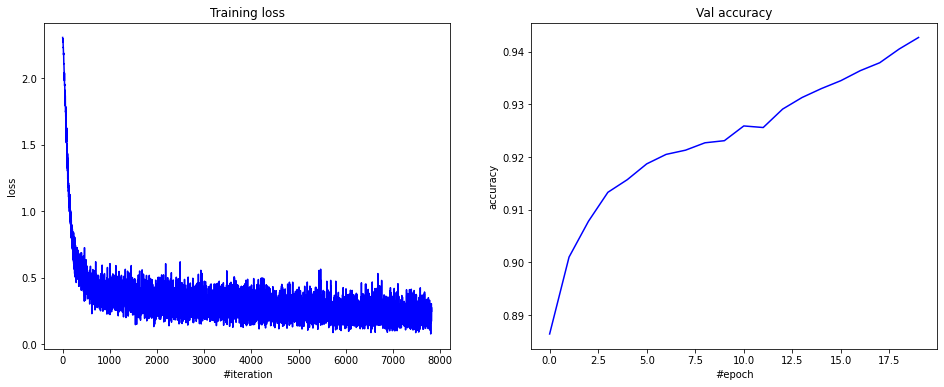

Current loss: 0.247885


In [15]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ELU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, sgd_momentum, optimizer_config, n_epoch, batch_size)

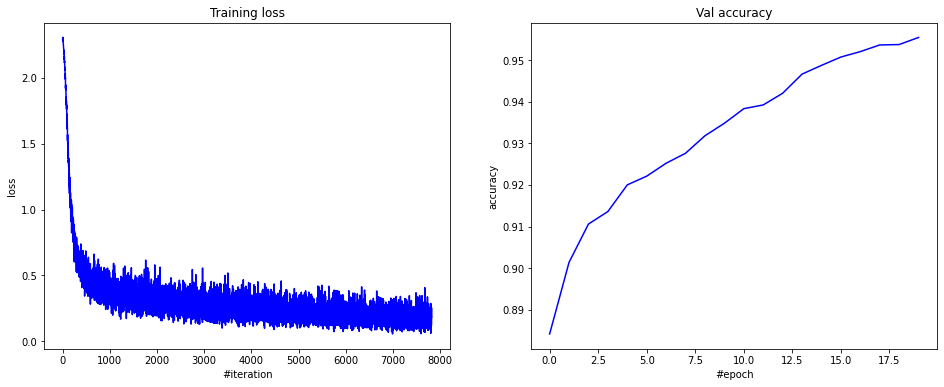

Current loss: 0.183638


In [16]:
net = Sequential()
net.add(Linear(784, 128))
net.add(LeakyReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, sgd_momentum, optimizer_config, n_epoch, batch_size)

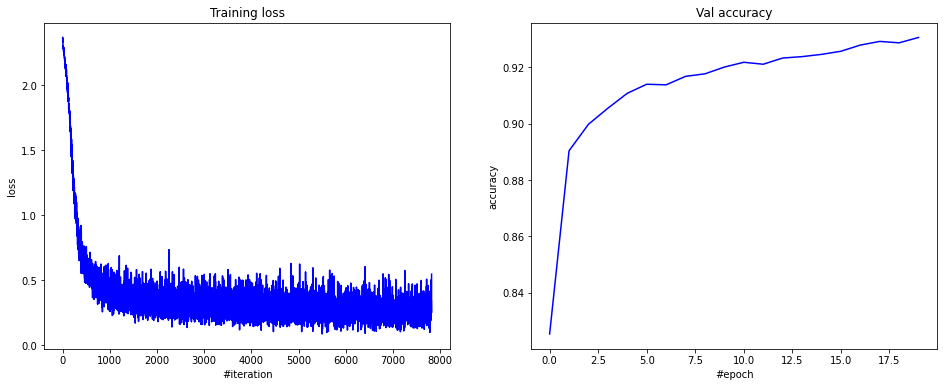

Current loss: 0.547626


In [17]:
net = Sequential()
net.add(Linear(784, 128))
net.add(SoftPlus())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, sgd_momentum, optimizer_config, n_epoch, batch_size)

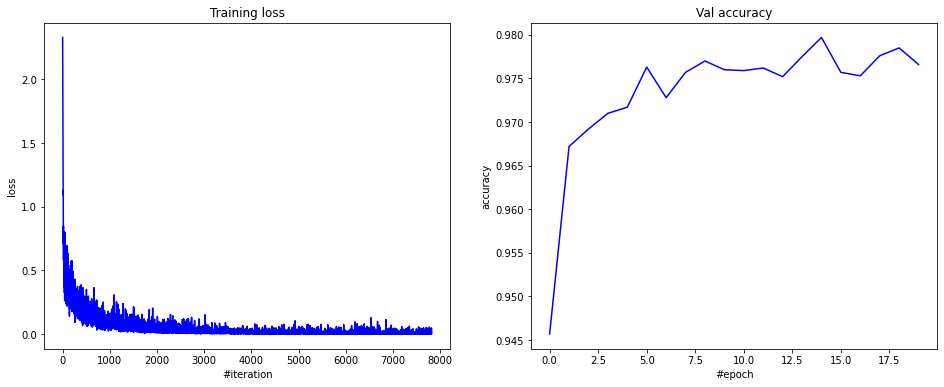

Current loss: 0.004104


In [18]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

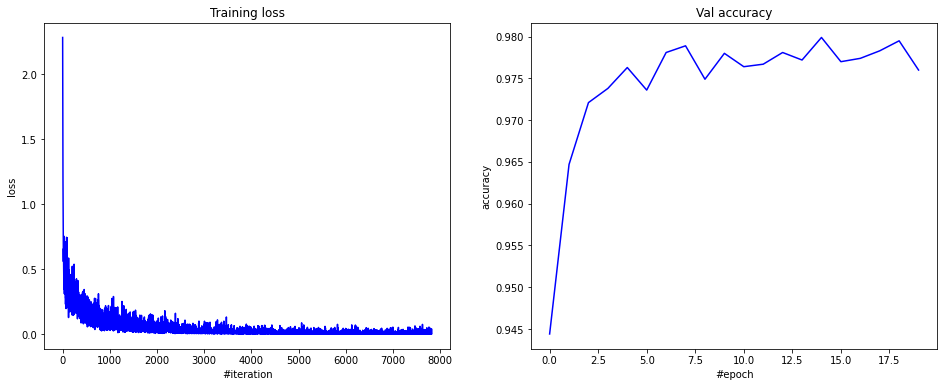

Current loss: 0.001047


In [19]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ELU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

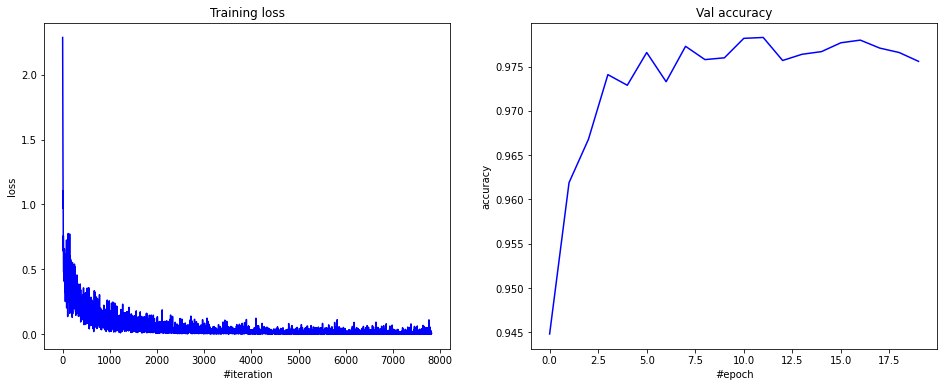

Current loss: 0.004379


In [20]:
net = Sequential()
net.add(Linear(784, 128))
net.add(LeakyReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

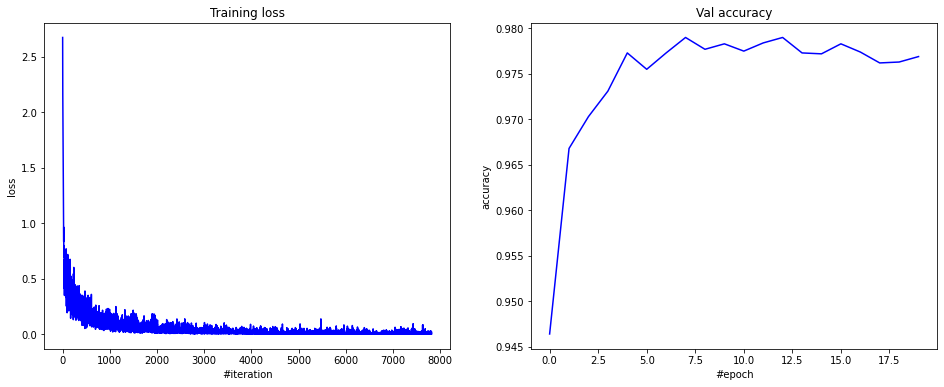

Current loss: 0.000119


In [21]:
net = Sequential()
net.add(Linear(784, 128))
net.add(SoftPlus())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

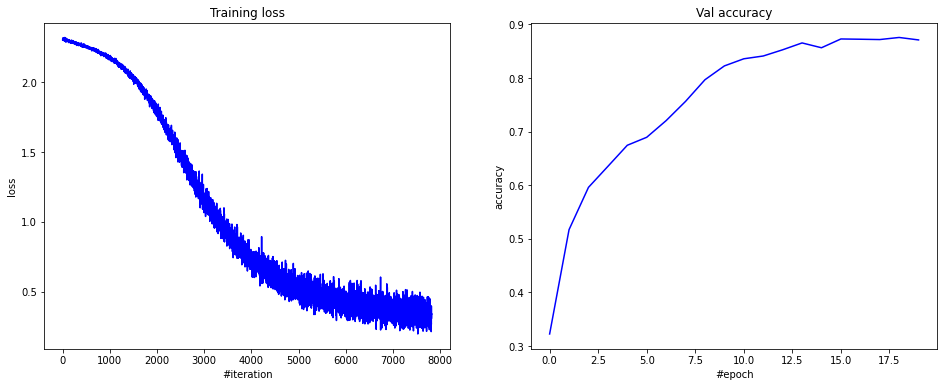

Current loss: 0.338996


In [22]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(BatchNormalization(0.9, 128))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, simple_sgd, optimizer_config, n_epoch, batch_size)

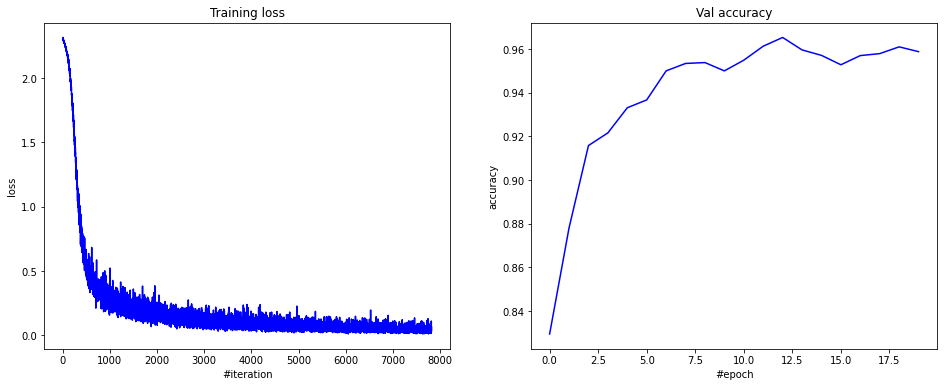

Current loss: 0.062389


In [23]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(BatchNormalization(0.9, 128))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, sgd_momentum, optimizer_config, n_epoch, batch_size)

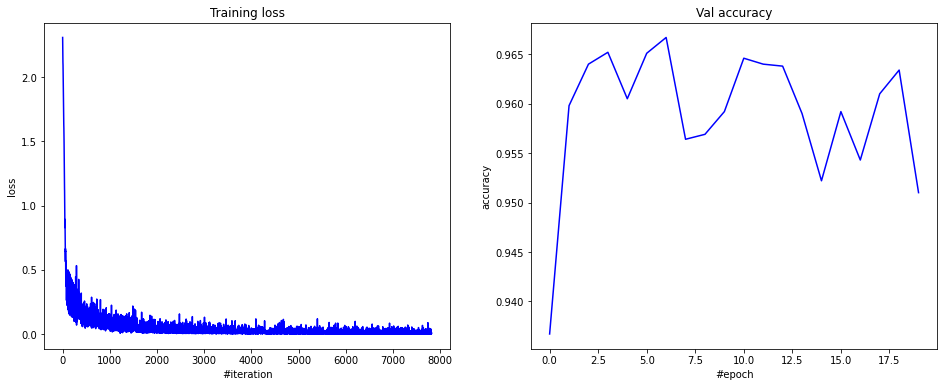

Current loss: 0.003750


In [24]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(BatchNormalization(0.9, 128))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [25]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

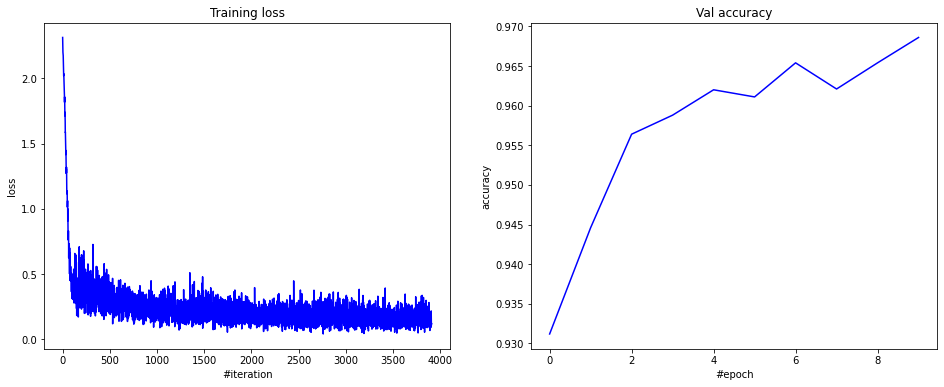

Current loss: 0.120735


In [26]:
# Your code goes here. ################################################

net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(BatchNormalization(0.9, 128))
net.add(ChannelwiseScaling(128))
net.add(Dropout(0.6))
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum': 0.9}
n_epoch = 10
batch_size = 128

investigate_net_on_mnist(net, criterion, adam_optimizer, optimizer_config, n_epoch, batch_size)

Print here your accuracy on test set. It should be around 90%.

In [27]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

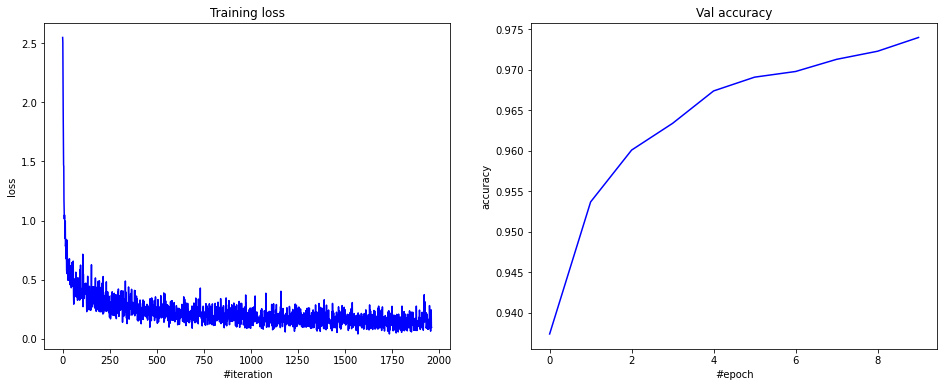

In [28]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.batch_norm = nn.BatchNorm1d(128, eps=BatchNormalization.EPS, momentum=1.-0.9, affine=True)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
learning_rate = 3e-03
momentum = 0.9
n_epochs = 10
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_accuracies = []
test_counter = [i*len(X_train) for i in range(n_epochs + 1)]
log_interval = 2

def train(epoch):
    network.train()
    batch_idx = 0
    for data, target in tqdm(get_batches((X_train, y_train), batch_size)):
        data = torch.from_numpy(data)
        target = torch.from_numpy(target)
        optimizer.zero_grad()
        output = network(data)
        # output = output.argmax(axis=-1)
        target = target.argmax(axis=-1)
        # print(output)
        # print(target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            # display.clear_output(wait=True)
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(X_train), 100. * batch_idx / len(X_train), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(X_train)))
        batch_idx += 1


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(get_batches((X_test, y_test), batch_size)):
            data = torch.from_numpy(data)
            target = torch.from_numpy(target)
            output = network(data)
            # output = output.argmax(axis=-1)
            target = target.argmax(axis=-1)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(X_test)
    test_losses.append(test_loss)
    display.clear_output(wait=True)
    accuracy = 100. * correct / len(X_test)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(X_test), accuracy))
    test_accuracies.append(accuracy_score(network(torch.from_numpy(X_val)).argmax(axis=-1), y_val.argmax(axis=-1)))

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

display.clear_output(wait=True)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(train_losses, 'b')

plt.subplot(1, 2, 2)
plt.title("Val accuracy")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(test_accuracies, 'b')
plt.show()